In [27]:
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip
from shapely.geometry import Polygon, shape
import asf_search as asf
import concurrent.futures
from tqdm import tqdm
import mpire
import backoff
import requests

In [28]:
START_DATE = '2021-01-01'
END_DATE = '2022-01-01'

# Read the disturbance Data

In [29]:
df_dist_hls_val = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/referenceTimeSeries_last.csv')
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


# Extracting "change" and Last observed "no change" indices

In [30]:
def get_index(data: list[str], val: str) -> int:
    try:
        ind = data.index(val)
    except ValueError:
        ind = len(data)
    return ind


def get_first_change(labeled_ts):
    get_index_p = lambda val: get_index(labeled_ts, val)
    indices = list(map(get_index_p, ['VLmin', 'VLmaj', 'OCmin', 'OCmaj']))
    ind = min(indices)
    ind = ind if ind < len(labeled_ts) else -1
    return ind

def get_last_noChange(labeled_ts, change_ind):
    if change_ind == -1:
        return -1
    labeled_ts_r = (labeled_ts[:change_ind][::-1])
    ind_nc_r = get_index(labeled_ts_r, 'noChange')
    ind_nc = change_ind - ind_nc_r - 1
    return ind_nc

Debugging/testing

In [31]:
IND_T = 2
row_data = list(df_dist_hls_val.iloc[IND_T])
ts_labeled = row_data[5:]
ind_c = get_first_change(ts_labeled)
ts_labeled[max(ind_c-10, 0): ind_c+10], ind_c

(['noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin'],
 119)

In [32]:
ind_nc = get_last_noChange(ts_labeled, ind_c)
ts_labeled[max(ind_nc, 0) : ind_c+ 1], ind_c

(['noChange',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin'],
 119)

## Extract dates from Table

In [33]:
def get_first_change_from_row(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        change_date = dates[ind_c]
    else:
        change_date = pd.NaT
    return change_date

def get_last_obs_date_before_change(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        ind_nc = get_last_noChange(labeled_ts, ind_c)
        last_obs_date = dates[ind_nc] if ind_nc > -1 else pd.NaT
    else:
        last_obs_date = pd.NaT

    return last_obs_date


In [34]:
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


In [35]:
change_times = df_dist_hls_val.apply(get_first_change_from_row, axis=1)
last_obs_times = df_dist_hls_val.apply(get_last_obs_date_before_change, axis=1)
change_labels = df_dist_hls_val.overallLabel[:10]
print(list(zip(change_times,last_obs_times, change_times > last_obs_times ,change_labels)))

[(Timestamp('2021-10-08 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-06 00:00:00'), True, 'VLmin'), (Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-02 00:00:00'), True, 'VLmaj'), (Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-11 00:00:00'), True, 'VLmaj'), (Timestamp('2021-10-03 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-03 00:00:00'), True, 'OCmin'), (NaT, NaT, False, 'noChange'), (NaT, NaT, False, 'noChange')]


<Axes: >

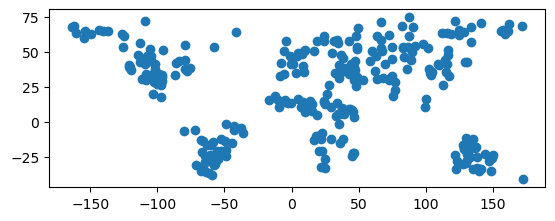

In [36]:
df_sites = gpd.GeoDataFrame({'site_id': df_dist_hls_val.ID,
                             'change_label': df_dist_hls_val.overallLabel,
                             'change_time': change_times,
                             'last_observation_time': last_obs_times},
                             geometry=gpd.points_from_xy(df_dist_hls_val.Long,
                                                         df_dist_hls_val.Lat),
                            crs=CRS.from_epsg(4326))
df_sites.plot()

In [37]:
df_sites.to_file('dist_hls_val_sites.geojson', driver='GeoJSON')

# Burst Ids

In [38]:
df_burst = read_geojson_gzip('../1_visualize_rtc_time_series/opera_burst_ids.geojson.zip')
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


# Join Burst table and the site ids

Via a spatial join

In [39]:
df_val_bursts = gpd.sjoin(df_burst, df_sites, how='inner', predicate='intersects').reset_index(drop=True)
df_val_bursts = df_val_bursts.drop_duplicates()
df_val_bursts = df_val_bursts.drop(columns=['index_right'])
df_val_bursts['track_number'] = df_val_bursts.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))
df_val_bursts = df_val_bursts.sort_values(by=['site_id', 'burst_id_jpl']).reset_index(drop=True)
df_val_bursts.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number
0,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2...",t090_193169_iw1,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,90
1,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",t097_207419_iw2,1,False,DESCENDING,1,VLmaj,2021-10-08,NaT,97
2,"POLYGON ((-53.01716 -23.54912, -52.25936 -23.3...",t163_349964_iw3,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,163
3,"POLYGON ((129.82540 -29.63759, 130.62076 -29.4...",t039_083584_iw3,1,False,ASCENDING,2,noChange,NaT,NaT,39
4,"POLYGON ((130.49640 -29.60892, 129.63063 -29.4...",t075_160202_iw1,1,False,DESCENDING,2,noChange,NaT,NaT,75


<Axes: >

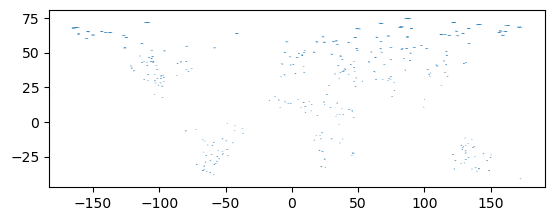

In [40]:
df_val_bursts.plot()

# Multiple bursts overlapping sites at high latitudes

In [41]:
df_burst_count = df_val_bursts[['site_id', 'orbit_pass']].groupby('site_id').count().sort_values(by='orbit_pass', ascending=False).reset_index(drop=False)
df_burst_count.head(10)

,site_id,orbit_pass
0,80,11
1,36,10
2,45,9
3,85,9
4,49,9
5,157,9
6,81,8
7,71,8
8,39,8
9,218,8


In [42]:
df_val_bursts.to_file('dist_val_bursts.geojson', driver='GeoJSON')

<Axes: >

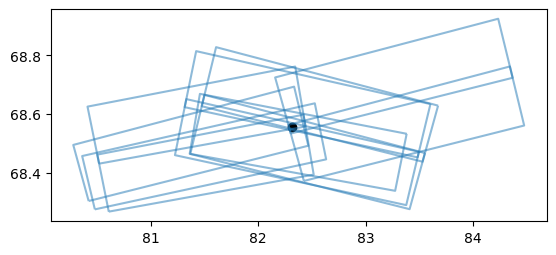

In [43]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts[df_val_bursts.site_id == 80].exterior.plot(ax=ax, alpha=.5)

## Get only 2 bursts from ASC/DSC

In [46]:
df_val_bursts_filtered = df_val_bursts.groupby(['site_id', 'orbit_pass']).head(2).reset_index(drop=True)
df_val_bursts_filtered.shape, df_val_bursts.shape

((929, 10), (1117, 10))

<Axes: >

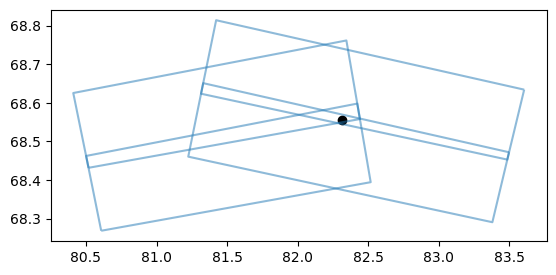

In [47]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts_filtered[df_val_bursts_filtered.site_id == 80].exterior.plot(ax=ax, alpha=.5)

# Getting SLC IDs

In [48]:
@backoff.on_exception(backoff.expo,
                      (requests.exceptions.ReadTimeout,
                       requests.exceptions.ConnectionError,
                      RuntimeError))
def get_asf_results(*,geo: Point,
                    site_id: int,
                    track_number: int,
                    burst_id_jpl: str,
                    **kwargs):
    
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=geo.wkt,
                         #maxResults=5_000,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         relativeOrbit=[track_number],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=START_DATE,
                         end=END_DATE
                         )
    df_res = pd.DataFrame()
    if res:
        geometry = [shape(r.geojson()['geometry']) for r in res]
        data = [r.properties for r in res]

        df_res = pd.DataFrame(data)
        df_res = gpd.GeoDataFrame(df_res,
                                  geometry=geometry,
                                  crs=CRS.from_epsg(4326))
        df_res['site_id'] = site_id
        df_res['jpl_burst_id'] = burst_id_jpl

    return df_res

def get_asf_results_from_record(record) -> gpd.GeoDataFrame:
    df = get_asf_results(geo=record['geometry'], site_id=record['site_id'], track_number=record['track_number'], burst_id_jpl=record['burst_id_jpl'])
    return df

We want the site point for the query as it's more exact.

In [49]:
df_query = df_val_bursts_filtered.copy()
df_query = df_query.drop(columns=['geometry'])
df_query = pd.merge(df_query, df_sites[['site_id', 'geometry']], how='left', on='site_id')
df_query.shape

(929, 10)

In [50]:
records = df_query.to_dict('records')
records[:2]

[{'burst_id_jpl': 't090_193169_iw1',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'ASCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 90,
  'geometry': <POINT (-52.38 -23.297)>},
 {'burst_id_jpl': 't097_207419_iw2',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'DESCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 97,
  'geometry': <POINT (-52.38 -23.297)>}]

In [51]:
get_asf_results_from_record(records[4]).head(2)

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,-30.2049,128.9823,2021-12-14T20:45:08Z,S1B_IW_SLC__1SDV_20211214T204440_20211214T2045...,DESCENDING,75,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-12-14T20:44:40Z,S1B_IW_SLC__1SDV_20211214T204440_20211214T2045...,...,2021-12-14T20:44:40Z,C-SAR,S1B_IWDV_0691_0698_030026_075,003.40,S1B_IW_SLC__1SDV_20211214T204440_20211214T2045...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((130.02199 -31.33954, 130.51625 -29.6...",2,t075_160202_iw1
1,-28.6952,129.4426,2021-12-14T20:44:42Z,S1B_IW_SLC__1SDV_20211214T204415_20211214T2044...,DESCENDING,75,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-12-14T20:44:15Z,S1B_IW_SLC__1SDV_20211214T204415_20211214T2044...,...,2021-12-14T20:44:15Z,C-SAR,S1B_IWDV_0686_0693_030026_075,003.40,S1B_IW_SLC__1SDV_20211214T204415_20211214T2044...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((130.47736 -29.79694, 130.94119 -28.1...",2,t075_160202_iw1


In [53]:
#dfs = list(map(get_asf_results_from_record, tqdm(records)))

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    dfs = list(tqdm(executor.map(get_asf_results_from_record, records[:]), total=len(records)))

 60%|███████████████████████████████████████▊                          | 560/929 [13:35<08:01,  1.31s/it]

In [ ]:
df_slcs.to_file('slcs_resp.geojson', driver='GeoJSON')

In [ ]:
df_slcs = pd.concat(dfs, axis=0)
df_slcs.head()

In [ ]:
df_slcs.shape

# Multiple bursts per date, burst id

A site might occur between overlapping frames

In [ ]:
df_slcs = gpd.read_file('slc_resp.geojson')

In [ ]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slcs['north_lat_neg'] = -df_slcs.geometry.bounds.maxy
df_slcs.sort_values(by=['jpl_burst_id', 'date_acquired_str', 'north_lat'], inplace=True)

In [ ]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slc_per_date_count = df_slcs[['jpl_burst_id', 'date_acquired_str', 'site_id', 'fileID']].groupby(['jpl_burst_id', 'date_acquired_str']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_date_count.head(4)

In [ ]:
df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].head()

In [ ]:
df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].exterior.plot()

Let's only get one of these.

In [ ]:
df_slcs_filtered = df_slcs.groupby(['jpl_burst_id', 'date_acquired_str']).head(1)
df_slcs_filtered.shape

The plot is better now

In [ ]:
fig, ax = plt.subplots()
df_slcs_filtered[df_slcs_filtered.jpl_burst_id == 't021_043849_iw2'].exterior.plot(ax =ax)
df_sites[df_sites.site_id == 264].plot(ax=ax)

In [ ]:
compression_options = dict(method='zip', archive_name=f'slcs_for_processing.csv')
df_slcs_filtered.to_csv('slcs_for_processing.csv.zip', compression=compression_options, index=False)